[e]:https://finance.yahoo.com/quote/FCEL 

## Learning: Stock Prediction Using Python and Machine Learning

This program utilizes artificial recurrent neural networks known as Long Short Term Memory (LSTM) to predict the closing stock price of [FuelCell Energy Inc.][e] stock using the past 60 day stock prices.


In [1]:
#Import necessary modules and libraries

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from yahoo_fin.stock_info import get_data
import datetime as dt


In [2]:
# Read data
# Rename and reformat pricing to 2 decimal places 
def read_data(tick_symbol, start_date, end_date):
    data = get_data(tick_symbol, start_date=start_date, end_date=end_date, index_as_date = False)
    return data
df = read_data('AMZN', '2017-01-01', '2021-08-23')

#my_date = dt.strptime(dataset1[, "%Y-%m-%d")


In [3]:
#get number of rows and col
df.shape

(1167, 8)

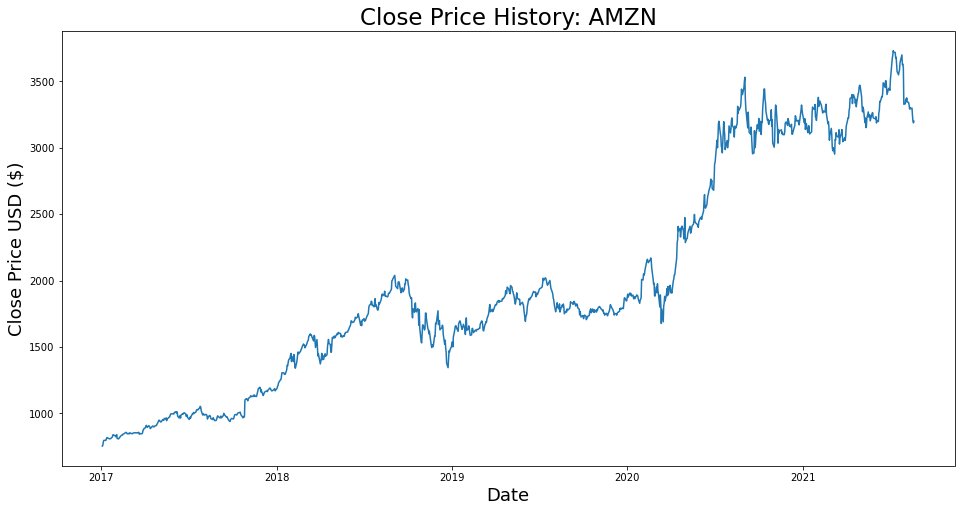

In [4]:
#visualise the close price
import seaborn as sns
plt.figure(figsize = (16, 8))
plt.title('Close Price History: AMZN', fontsize = 23)
sns.lineplot(x = df['date'], y = df['close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [3]:
def pre_process(data):
    #Create dataframe with close column only
    data = data.filter(['close'])

    #convert dataframe to numpy array
    dataset = data.values #.values is used to represent a dataframe into an array

   
    #feature scale data to smoothen dataset before training neural network
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset) #computes min and max for scaling and transforms data (0 and 1 inclusive)
    
    return scaled_data, scaler
        

In [4]:
def create_training(scaled_data, timestep, training_data_length):
    #create training dataset
    #create scaled training dataset
    train_data = scaled_data[0:training_data_length , :]
    #Split data into x and y training datasets 
    x_train = []
    y_train = []

    #Append train set for 
    for i in range(timestep, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    
    return x_train, y_train

In [5]:
#Create testing dataset
#Create new array using scaled values 
def create_test(data, scaled_data, training_data_length, timestep):
    test_data = scaled_data[training_data_length - timestep:, :]
    
    #create datasets x_test and y_test
    x_test = []
    y_test = data.iloc[training_data_length:,:]
    y_test = y_test['close'].values
    for i in range(timestep, len(test_data)):
        x_test.append(test_data[i-60:i, 0]) #past 60 day values
    
    return x_test, y_test


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)               

<ipython-input-14-a540fb0c1f5b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


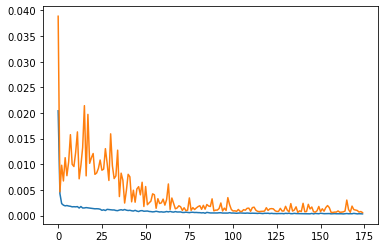

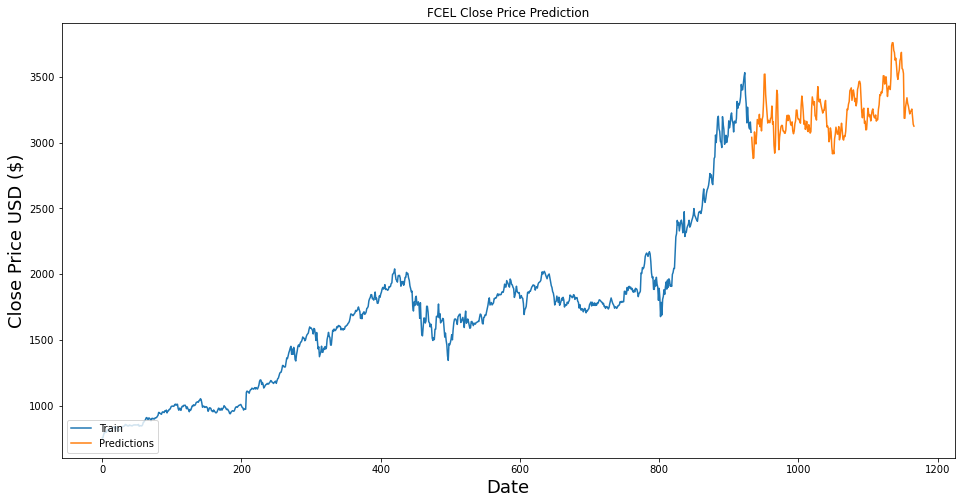

In [14]:
if __name__ == "__main__":
    data = read_data('AMZN', '2017-01-01', '2021-08-23')
            
    scaled_data, scaler = pre_process(data)
    
    #Convert x_train and y_train to numpy arrays
    training_data_length = int(len(scaled_data)*0.8)
    
    timestep = 60
    
    x_train, y_train = create_training(scaled_data, timestep, training_data_length)
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape, must be in 3D only x train is in 2D
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #first and second column of x train datasets (no. of rows, time steps, no. of features i.e. closing price)
    
    x_test, y_test = create_test(data, scaled_data, training_data_length, timestep)
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
      
    #Create the neural network 
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    print(model.summary())
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    

    history = model.fit(x_train, y_train, epochs = 175, validation_split = 0.1, verbose = 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    #Get models predicted closing price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) #unscale values to get price not scaled data

    rootMean = np.sqrt(np.mean(predictions - y_test)**2)
    print("RMSE: " + str(rootMean))
    
    #Plot data
    train = data[:training_data_length]
    valid = data[training_data_length:]
    valid['Predictions'] = predictions
    #Visualize data
    plt.figure(figsize=(16, 8))
    plt.title('FCEL Close Price Prediction')
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Close Price USD ($)', fontsize = 18)
    plt.plot(train['close'])
    plt.plot(valid[['Predictions']])
    plt.legend(['Train', 'Predictions'], loc = 'lower left')
    plt.show() 
    

In [20]:
#Show actual (valid) prices
valid

,date,open,high,low,close,adjclose,volume,ticker,Predictions
933,2020-09-17,3009.250000,3029.429932,2972.550049,3008.729980,3008.729980,6449100,AMZN,3039.367676
934,2020-09-18,3031.739990,3037.800049,2905.540039,2954.909912,2954.909912,8892600,AMZN,2948.183594
935,2020-09-21,2906.500000,2962.000000,2871.000000,2960.469971,2960.469971,6117900,AMZN,2879.295654
936,2020-09-22,3033.840088,3133.989990,3000.199951,3128.989990,3128.989990,6948800,AMZN,2883.852295
937,2020-09-23,3120.429932,3127.000000,2992.379883,2999.860107,2999.860107,5652700,AMZN,3080.807861
...,...,...,...,...,...,...,...,...,...
1162,2021-08-16,3283.000000,3300.000000,3211.129883,3298.989990,3298.989990,3319700,AMZN,3240.915283
1163,2021-08-17,3277.500000,3280.489990,3225.679932,3241.959961,3241.959961,3387900,AMZN,3254.570557
1164,2021-08-18,3241.989990,3254.100098,3200.000000,3201.219971,3201.219971,2804300,AMZN,3192.836670
1165,2021-08-19,3194.020020,3233.000000,3182.459961,3187.750000,3187.750000,3782900,AMZN,3138.755615


In [23]:
#Get quotes for the 24th August
amzn_quote = read_data('AMZN', '2017-01-01', '2021-08-24')

new_df = amzn_quote.filter(['close'])

#get last 60 days closing price and convert dataframe to an array
#60 becuase it's our timestep
last_60 = new_df[-60:].values

#scale data
last_60_scaled = scaler.transform(last_60)

X_test_new = []

#Append past 60 days
X_test_new.append(last_60_scaled)

#Convert X_test to numpy array
X_test_new = np.array(X_test_new)

#Reshape to 3D format for LSTM
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))

#Get prediction
predicted_price = model.predict(X_test_new)

#Undo and revert back to price
predicted_price = scaler.inverse_transform(predicted_price)
print(predicted_price)

[[3243.6575]]


In [26]:
#Print actual price of fcel at the particular day
actual_amzn_price = read_data('AMZN', '2021-08-24', '2021-08-25')
print(actual_amzn_price['close'].values)

[3305.7800293]
